In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data preparation

## CSL air quality data

In [9]:
csl_data = pd.read_csv("data/csl-data.csv", na_values=-1)
csl_data['timestamp'] = pd.to_datetime(csl_data['timestamp'],unit='s')
csl_data = csl_data.drop(['minute', 'hour', 'day', 'month','year'], axis=1) #wrong timezone (BST)
csl_data = csl_data[['timestamp', 'AQI-1hr-index']] #drop columns relating to AQI
csl_data = csl_data.set_index('timestamp')
csl_data = csl_data.resample('H').mean()
csl_data = csl_data.dropna()
csl_data.head()

,AQI-1hr-index
timestamp,
2020-06-27 19:00:00,19.941038
2020-06-27 20:00:00,20.874941
2020-06-27 21:00:00,24.001887
2020-06-27 22:00:00,29.249528
2020-06-27 23:00:00,30.633962


## City centre weather data

In [12]:
from datetime import timedelta

centre_data = pd.read_csv("data/cardiff-centre-data.csv")
data_cols = ['Date', 'Time', 'Modelled Wind Direction', 'Modelled Wind Speed', 'Modelled Temperature']
centre_data = centre_data[data_cols]
centre_data = centre_data.drop(centre_data.shape[0]-1) #drop last row, which is invalid
centre_data['Date'] = pd.to_datetime(centre_data['Date'])
def fix_centre_dates(row):
    if row.Time == '24:00:00':
        row.Time = '00:00:00'
        row.Date = row.Date + timedelta(days=1)
    return row
centre_data = centre_data.apply(fix_centre_dates, axis=1)
centre_data['Date'] = pd.to_datetime(centre_data['Date'].apply(lambda d: d.strftime('%Y-%m-%d'))+' '+centre_data['Time'])
centre_data = centre_data.drop(['Time'], axis=1)
centre_data.columns = ['Date', 'Wind_dir', 'Wind_spd', 'Temperature']
centre_data = centre_data.set_index('Date')
centre_data[centre_data.columns] = centre_data[centre_data.columns].apply(pd.to_numeric, errors='coerce')
centre_data.head()

,Wind_dir,Wind_spd,Temperature
Date,,,
2020-06-23 01:00:00,210.0,2.7,10.7
2020-06-23 02:00:00,199.5,2.8,10.3
2020-06-23 03:00:00,209.8,3.4,10.7
2020-06-23 04:00:00,215.0,2.6,10.9
2020-06-23 05:00:00,195.7,1.9,10.8


## Joining the two datasets

In [13]:
full_data = csl_data.join(centre_data)
full_data = full_data.dropna()

full_data.head()

,AQI-1hr-index,Wind_dir,Wind_spd,Temperature
timestamp,,,,
2020-06-27 19:00:00,19.941038,252.8,8.9,14.1
2020-06-27 20:00:00,20.874941,249.3,8.4,13.0
2020-06-27 21:00:00,24.001887,247.9,8.8,12.5
2020-06-27 22:00:00,29.249528,250.4,8.9,12.6
2020-06-27 23:00:00,30.633962,254.6,8.4,12.3


# Data analysis

## Temperature

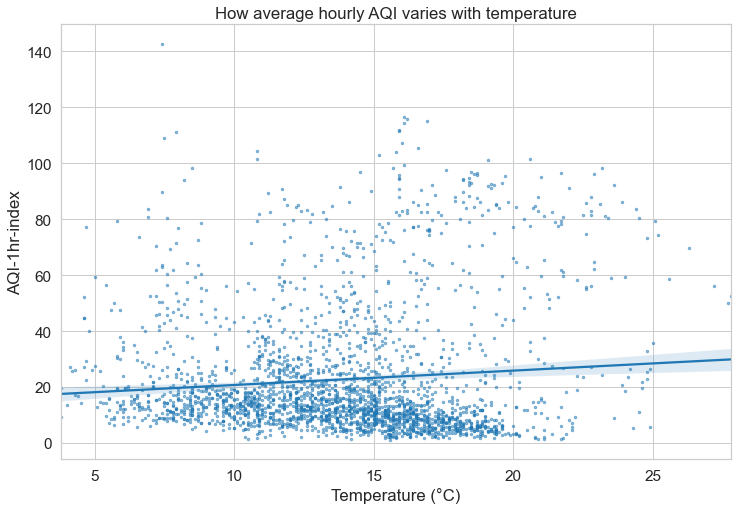

In [31]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.4)

plt.figure(figsize=(12, 8))
sns.regplot(data=full_data, x='Temperature', y='AQI-1hr-index', scatter_kws={'s':6, 'alpha':0.5},)
plt.title("How average hourly AQI varies with temperature")
plt.xlabel("Temperature (°C)");

## Wind speed

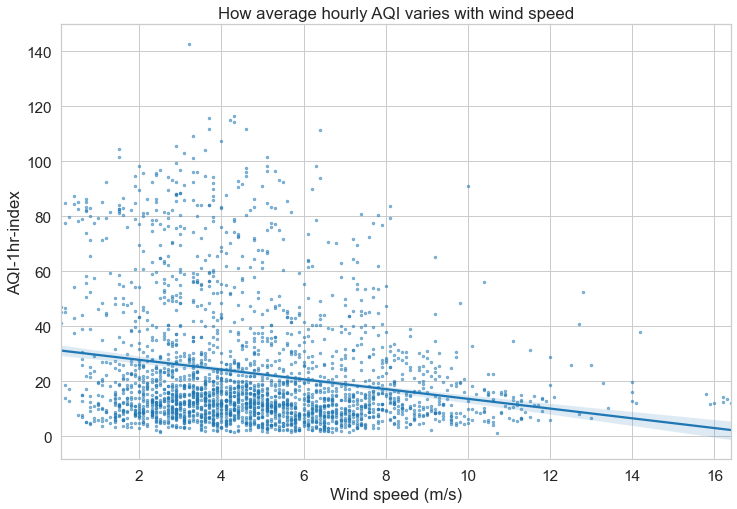

In [32]:
plt.figure(figsize=(12, 8))
sns.regplot(data=full_data, x='Wind_spd', y='AQI-1hr-index', scatter_kws={'s':6, 'alpha':0.5},)
plt.title("How average hourly AQI varies with wind speed")
plt.xlabel("Wind speed (m/s)");

## Wind direction

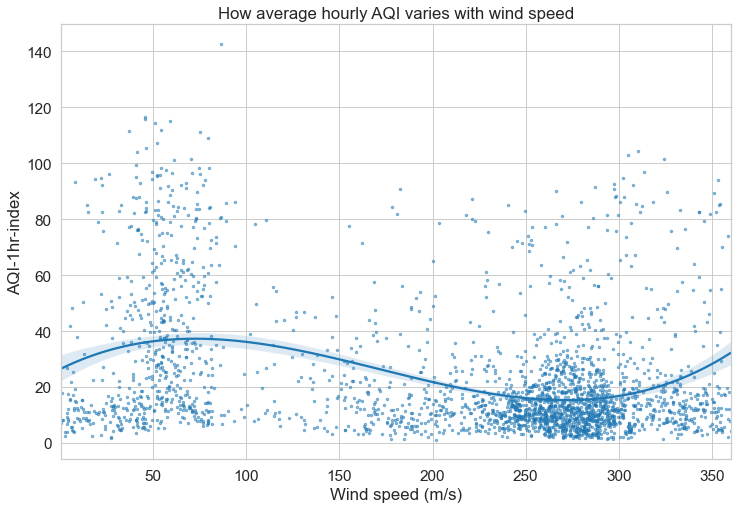

In [33]:
plt.figure(figsize=(12, 8))
sns.regplot(data=full_data, x='Wind_dir', y='AQI-1hr-index', scatter_kws={'s':6, 'alpha':0.5},
            order=3)
plt.title("How average hourly AQI varies with wind speed")
plt.xlabel("Wind speed (m/s)");

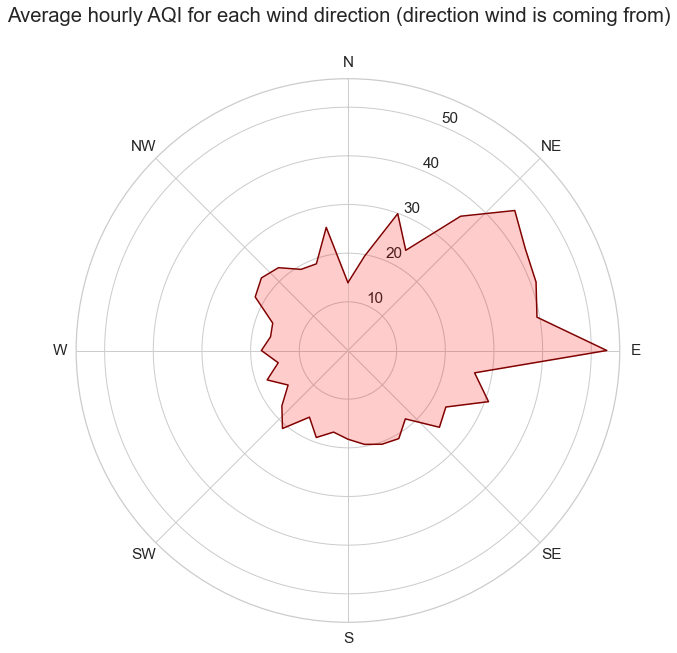

In [37]:
from math import radians

full_data['Wind_dir_round'] = full_data['Wind_dir'].round(-1)
averages_for_wind_dir = full_data.groupby('Wind_dir_round').mean()
#0 and 360 degrees refer to the same direction, so should be the same
averages_for_wind_dir.loc[0] = (averages_for_wind_dir.loc[0] + averages_for_wind_dir.loc[360]) / 2
averages_for_wind_dir.loc[360] = averages_for_wind_dir.loc[0]

f = plt.figure(figsize=(10,10))
f.suptitle("Average hourly AQI for each wind direction (direction wind is coming from)")

ax = f.add_subplot(111, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
ax.plot([radians(x) for x in averages_for_wind_dir.index.values], 
averages_for_wind_dir['AQI-1hr-index'].values, color='maroon')
plt.fill_between([radians(x) for x in averages_for_wind_dir.index.values],
                 averages_for_wind_dir['AQI-1hr-index'].values, 0,
                 facecolor="red", alpha=0.2)